# Disseration Experiment 4e
# Generate LIME - IDENTITY + STABILITY Metric October Twenty Four¶
Ciaran Finnegan October 2023

# Import Libraries + Custom Functions

## Import Libraries

In [1]:
# Import libs
import numpy as np
import pandas as pd
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
import shap
import random

from IPython.display import display, HTML

# Import necessary libraries for ANN model building
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Import necessary libraries for LIME calculations
import lime
import lime.lime_tabular

# Libraries required for metrics calculations
from scipy.spatial import distance
from sklearn.cluster import KMeans

from sklearn.preprocessing import LabelEncoder
import warnings
import sklearn.metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample


# Classifier training (not used for explainability)
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

## Custom Functions

Dataset Visualisations

In [2]:
%run ./DS_Visualisation_Functions.ipynb

Metrics

In [3]:
%run ./XAI_Metrics_Functions.ipynb

# Data Visualisation and Exploration

## Import Data

In [4]:
ds_file_to_load = 'credit_default_data.csv'
df = pd.read_csv(ds_file_to_load)

## Data Exploration

### Dataset Structure

In [5]:
def styled_dataframe(df):
    header_styles = {
        'selector': 'th',
        'props': [('text-align', 'center')]
    }
    
    body_styles = {
        'selector': 'td',
        'props': [('text-align', 'center')]
    }
    
    general_styles = {
        'selector': 'table',
        'props': [('background-color', '#f4f4f4'),
                  ('color', '#000000'),
                  ('border-color', '#e0e0e0'),
                  ('border', '1px solid #e0e0e0'),
                  ('font-family', 'Arial, sans-serif'),
                  ('width', '100%'),
                  ('font-size', '12px'),  # Reduce font size
                  ('padding', '5px')]     # Adjust cell padding
    }
    
    # Apply the styles to the dataframe
    styled_df = (df.style.set_table_styles([general_styles, header_styles, body_styles])
                 .set_properties(subset=df.columns, 
                                 **{'min-width': '150px',  # Adjust column width
                                    'padding': '5px'})  # Adjust cell padding
                 .format(None, na_rep='NA'))
    
    # Convert styled dataframe to HTML and wrap in a div container for scrolling
    styled_html = f'<div style="width:100%; overflow-x:auto;">{styled_df.to_html()}</div>'
    
    return display(HTML(styled_html))

In [6]:
# Display the first few rows of the dataset to understand its structure
#df.head()
#print(df.head().to_string())
styled_dataframe(df.head())

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [7]:
# Reset default Pandas display options
pd.reset_option('display.max_columns')
pd.reset_option('display.expand_frame_repr')
pd.reset_option('display.max_colwidth')
# Display the dataframe
display(df.head())

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


### Generate Visualizations

In [8]:
# Set up the target and features to be visualised

sTarget_feature = 'default'
sFeature_analysis_1 = 'LIMIT_BAL'
sFeature_analysis_2 = 'AGE'
sFeature_analysis_3 = 'SEX'
sFeature3_ticklabel1 = 'Male'
sFeature3_ticklabel2 = 'Female'

#### Generate Visualizations to better understand the data distribution and relationships between features.

##### Bar and Box Plot Visualisations

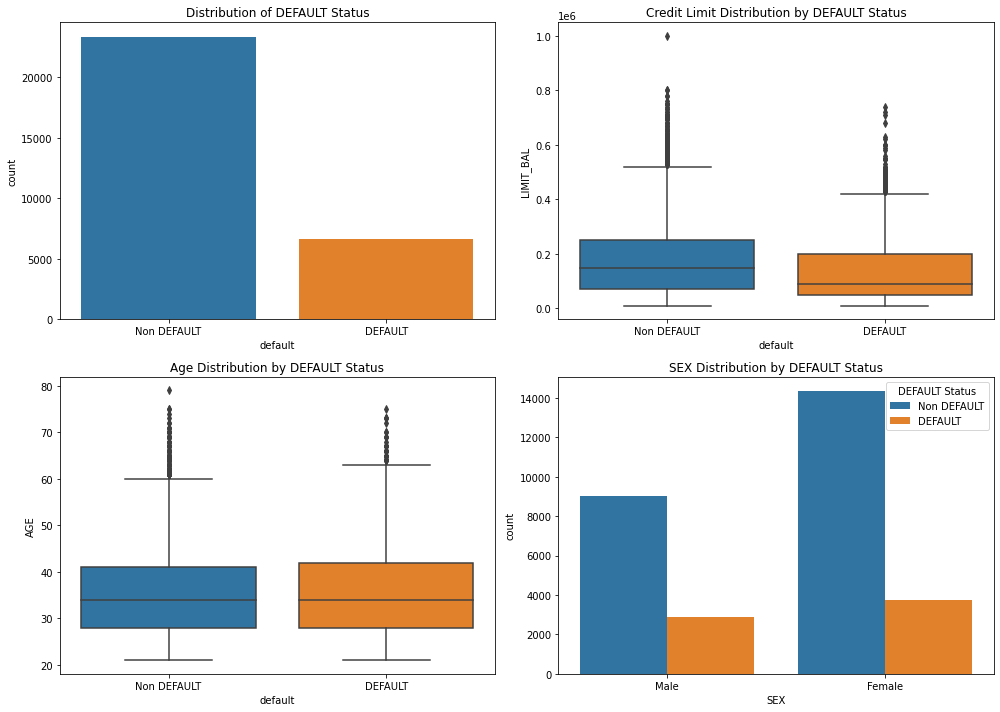

In [9]:
generate_box_plots(df, sTarget_feature, 
                       sFeature_analysis_1, 
                       sFeature_analysis_2, 
                       sFeature_analysis_3,
                       sFeature3_ticklabel1, 
                       sFeature3_ticklabel2)

#### Heatmap Visualisation

In [10]:
# Would need feature reduction to work effectively - or some other filtering

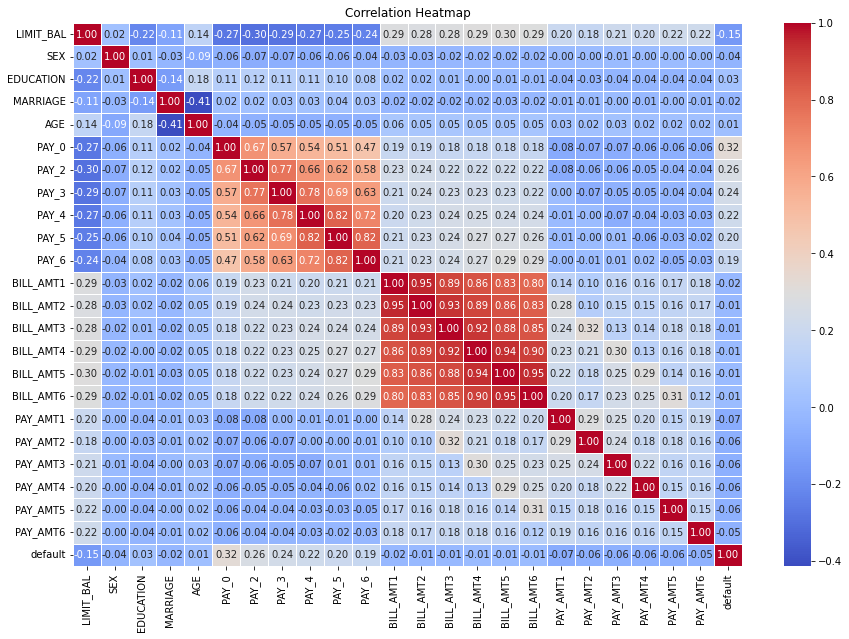

In [11]:
# Plotting correlation heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(df.corr(), cmap='coolwarm', annot=True, fmt=".2f", linewidths=.5)
plt.title("Correlation Heatmap")
plt.show()

#### Distributions

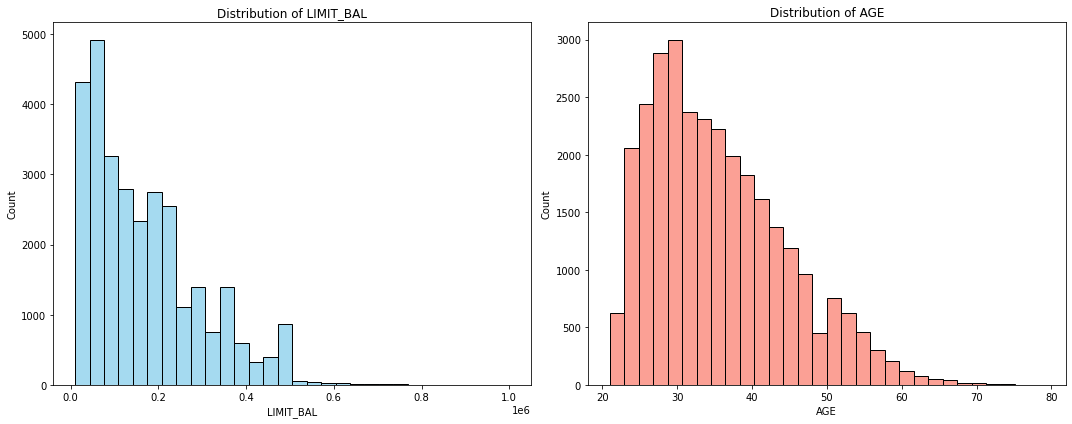

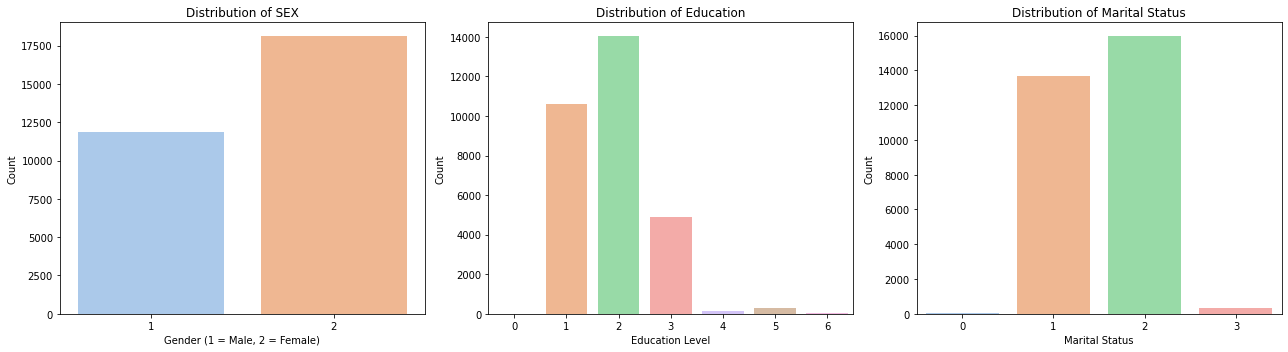

In [12]:
# Plotting distributions for continuous features
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

sns.histplot(df[sFeature_analysis_1], bins=30, ax=ax[0], color="skyblue")
ax[0].set_title("Distribution of "+sFeature_analysis_1.upper())
ax[0].set_xlabel(sFeature_analysis_1.upper())
#ax[0].set_xlabel("Credit Limit")
ax[0].set_ylabel("Count")

sns.histplot(df[sFeature_analysis_2], bins=30, ax=ax[1], color="salmon")
ax[1].set_title("Distribution of "+ sFeature_analysis_2.upper())
ax[1].set_xlabel(sFeature_analysis_2.upper())
ax[1].set_ylabel("Count")

plt.tight_layout()
plt.show()

# Plotting distributions for categorical features
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

sns.countplot(data=df, x=sFeature_analysis_3, ax=ax[0], palette="pastel")
ax[0].set_title("Distribution of " + sFeature_analysis_3.upper())
ax[0].set_xlabel("Gender (1 = Male, 2 = Female)")
ax[0].set_ylabel("Count")

sns.countplot(data=df, x="EDUCATION", ax=ax[1], palette="pastel")
ax[1].set_title("Distribution of Education")
ax[1].set_xlabel("Education Level")
ax[1].set_ylabel("Count")

sns.countplot(data=df, x="MARRIAGE", ax=ax[2], palette="pastel")
ax[2].set_title("Distribution of Marital Status")
ax[2].set_xlabel("Marital Status")
ax[2].set_ylabel("Count")

plt.tight_layout()
plt.show()


# Feature Engineering

## Check for Missing Data

In [13]:
# Determine the threshold for missing values
threshold = 0.75 * len(df)

# Identify columns with missing values greater than the threshold
missing_columns = df.columns[df.isnull().sum() > threshold]

# Print the columns with more than 75% missing values
print("Columns with more than 75% missing values:", missing_columns)

# Drop columns with missing values greater than the threshold
df = df.drop(columns=missing_columns)

# Save or continue processing with columns removed that had high volumes of missing data


Columns with more than 75% missing values: Index([], dtype='object')


In [14]:
# Display the first few rows of the dataset to re-check structure once any columns with 
# significant amounts of missing data have been removed
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


## Categorical Data 

In [15]:
# List of categorical columns
cat_cols = ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

In [16]:
# Adjust cat columns to range from 0
# df[cat_cols] = df[cat_cols] = df[cat_cols].apply(LabelEncoder().fit_transform)

In [17]:
# One-hot encode categorical variables
#df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)
df_encoded = pd.get_dummies(df, columns=cat_cols)

In [18]:
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [19]:
# Display the first few rows of the dataset to understand its structure
df_encoded.head()

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,...,PAY_6_-2,PAY_6_-1,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5,PAY_6_6,PAY_6_7,PAY_6_8
0,20000,24,3913,3102,689,0,0,0,0,689,...,1,0,0,0,0,0,0,0,0,0
1,120000,26,2682,1725,2682,3272,3455,3261,0,1000,...,0,0,0,1,0,0,0,0,0,0
2,90000,34,29239,14027,13559,14331,14948,15549,1518,1500,...,0,0,1,0,0,0,0,0,0,0
3,50000,37,46990,48233,49291,28314,28959,29547,2000,2019,...,0,0,1,0,0,0,0,0,0,0
4,50000,57,8617,5670,35835,20940,19146,19131,2000,36681,...,0,0,1,0,0,0,0,0,0,0


In [20]:
# display all columns
pd.set_option('display.max_columns', None)
print(df_encoded)

       LIMIT_BAL  AGE  BILL_AMT1  BILL_AMT2  BILL_AMT3  BILL_AMT4  BILL_AMT5  \
0          20000   24       3913       3102        689          0          0   
1         120000   26       2682       1725       2682       3272       3455   
2          90000   34      29239      14027      13559      14331      14948   
3          50000   37      46990      48233      49291      28314      28959   
4          50000   57       8617       5670      35835      20940      19146   
...          ...  ...        ...        ...        ...        ...        ...   
29995     220000   39     188948     192815     208365      88004      31237   
29996     150000   43       1683       1828       3502       8979       5190   
29997      30000   37       3565       3356       2758      20878      20582   
29998      80000   41      -1645      78379      76304      52774      11855   
29999      50000   46      47929      48905      49764      36535      32428   

       BILL_AMT6  PAY_AMT1  PAY_AMT2  P

# Build Model

## Downsample Majority Class

In [56]:
# Check the distribution of the target variable
target_distribution = df_encoded['default'].value_counts()

target_distribution

0    23364
1     6636
Name: default, dtype: int64

In [57]:
# Separate the majority and minority classes
df_majority = df_encoded[df_encoded['default'] == 0]
df_minority = df_encoded[df_encoded['default'] == 1]

In [58]:
# Downsample the majority class
df_majority_downsampled = resample(df_majority, 
                                   replace=False, 
                                   n_samples=target_distribution[1], 
                                   random_state=42)

In [59]:
# Combine the downsampled majority class with the minority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

In [60]:
# Shuffle the dataset to mix the data points
df_downsampled = df_downsampled.sample(frac=1, random_state=42).reset_index(drop=True)

In [61]:
# Display the distribution of the target variable in the downsampled dataset
df_downsampled['default'].value_counts()

0    6636
1    6636
Name: default, dtype: int64

## Split Features + Target

In [62]:
# Features and target variable
X = df_downsampled.drop('default', axis=1)
y = df_downsampled['default']

In [21]:
# Split data into features and target
#X = df_encoded.drop('default', axis=1)
#y = df_encoded['default']

## Split Data into Test/Training Datasets

In [63]:
# Splitting the data into training and testing sets
X_train_downsampled, X_test_downsampled, y_train_downsampled, y_test_downsampled = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [64]:
X_train_downsampled.shape, X_test_downsampled.shape

((10617, 91), (2655, 91))

### Basic Additional Data Exploration (Training Data)

In [65]:
# Train model Stats

print("Number of Features:", X_train_downsampled.shape[1])
print("Number Continuous Features:", X_train_downsampled.shape[1] - len(cat_cols))
print("Number Categorical Features:", len(cat_cols))
print("Number Train Examples:", X_train_downsampled.shape[0])
print("Number Positive Train Examples:", (y_train_downsampled == 1).sum())
print("Number Negative Train Examples:", (y_train_downsampled == 0).sum())

Number of Features: 91
Number Continuous Features: 82
Number Categorical Features: 9
Number Train Examples: 10617
Number Positive Train Examples: 5291
Number Negative Train Examples: 5326


## Build Neural Network (w/TensorFlow/Keras)

In [66]:
# Import necessary libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [67]:
# Define the model architecture
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_downsampled.shape[1],)),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

In [68]:
# Compile the model
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [69]:
# Train the model
history = model.fit(
    X_train_downsampled, y_train_downsampled,
    epochs=20,
    batch_size=64,
    validation_split=0.2,
    verbose=1
)

print("Model trained successfully!")

Epoch 1/20


The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.


133/133 [==============================] - 2s 4ms/step - loss: 3074.1602 - accuracy: 0.5140 - val_loss: 271.2060 - val_accuracy: 0.5297
Epoch 2/20
133/133 [==============================] - 0s 3ms/step - loss: 579.2487 - accuracy: 0.5149 - val_loss: 35.2968 - val_accuracy: 0.5207
Epoch 3/20
133/133 [==============================] - 0s 3ms/step - loss: 133.9081 - accuracy: 0.5205 - val_loss: 3.7545 - val_accuracy: 0.5410
Epoch 4/20
133/133 [==============================] - 0s 4ms/step - loss: 44.4381 - accuracy: 0.5112 - val_loss: 4.3898 - val_accuracy: 0.5377
Epoch 5/20
133/133 [==============================] - 0s 3ms/step - loss: 22.6868 - accuracy: 0.5341 - val_loss: 2.5644 - val_accuracy: 0.5767
Epoch 6/20
133/133 [==============================] - 1s 6ms/step - loss: 11.5294 - accuracy: 0.5249 - val_loss: 3.3128 - val_accuracy: 0.4845
Epoch 7/20
133/133 [==============================] - 0s 2ms/step - loss: 8.4882 - accuracy: 0.5210 - val_loss: 3.2031 - val_accuracy: 0.5410
Epoc

In [70]:
# Set Up Random Forest model
# Train the Random Forest classifier with the best parameters
#rf_classifier = RandomForestClassifier(**best_params, random_state=42)
#rf_classifier = RandomForestClassifier(random_state=42)
#rf_classifier.fit(X_train, y_train)

In [71]:
# Set up LGBMClassifier model
#lgbm_model = lgb.LGBMClassifier()

In [72]:
# Assign model
#model = rf_classifier 
#model = lgbm_model 

In [73]:
# Train chosen model
#model.fit(X_train, y_train)
# Retrain the Random Forest classifier on the downsampled data
#model.fit(X_train_downsampled, y_train_downsampled)

# Evaluate Model

## Assess Model Peformance

In [74]:
from IPython.display import display, HTML

In [75]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_downsampled, y_test_downsampled, verbose=1)

83/83 [==============================] - 0s 1ms/step - loss: 0.6930 - accuracy: 0.5073


In [76]:
# Predict probabilities
y_pred_probs = model.predict(X_test_downsampled)

83/83 [==============================] - 0s 969us/step


In [77]:
# Convert probabilities to binary predictions
y_pred = [1 if prob > 0.5 else 0 for prob in y_pred_probs]

In [78]:
# Compute additional evaluation metrics
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

In [79]:
precision = precision_score(y_test_downsampled, y_pred)
recall = recall_score(y_test_downsampled, y_pred)
f1 = f1_score(y_test_downsampled, y_pred)
roc_auc = roc_auc_score(y_test_downsampled, y_pred_probs)

In [80]:
# Creating a formatted table to display the results
table = """
<table>
    <tr>
        <th>Metric</th>
        <th>Value</th>
    </tr>
    <tr>
        <td>Test Accuracy</td>
        <td>{:.4f}</td>
    </tr>
    <tr>
        <td>Precision</td>
        <td>{:.4f}</td>
    </tr>
    <tr>
        <td>Recall</td>
        <td>{:.4f}</td>
    </tr>
    <tr>
        <td>F1-Score</td>
        <td>{:.4f}</td>
    </tr>
    <tr>
        <td>ROC-AUC Score</td>
        <td>{:.4f}</td>
    </tr>
</table>
""".format(test_accuracy, precision, recall, f1, roc_auc)

In [81]:
# Display the table
display(HTML(table))

Metric,Value
Test Accuracy,0.5073
Precision,0.5070
Recall,0.9985
F1-Score,0.6725
ROC-AUC Score,0.5012


# Generate LIME Values

In [88]:
# Importing necessary libraries
import lime
from lime import lime_tabular

In [89]:
# 1. Choosing an instance for which we want an explanation
instance = X_test_downsampled.iloc[0].values.reshape(1, -1)

In [90]:
# Wrapper function to output probabilities for both classes
def predict_proba_wrapper(data):
    # Get the probability of the positive class
    prob_pos = model.predict(data)
    # Get the probability of the negative class
    prob_neg = 1 - prob_pos
    # Combine and return the probabilities
    return np.hstack([prob_neg, prob_pos])

In [91]:
# 2-5. Creating a LIME explainer
# We use LIME's LimeTabularExplainer for tabular (table) data
# 'training_data' is the data used to train the model, required for LIME to sample perturbations
# 'mode' indicates we're dealing with a classification problem
# 'feature_names' are the names of the columns
explainer = lime_tabular.LimeTabularExplainer(X_train_downsampled.values, 
                                              mode='classification',
                                              training_labels=y_train_downsampled,
                                              feature_names=X_train_downsampled.columns)

In [92]:
# 6. Explaining the prediction using the LIME explainer
# Using our wrapper function for predictions
explanation = explainer.explain_instance(instance[0], predict_proba_wrapper)

157/157 [==============================] - 0s 1ms/step


In [93]:
# Displaying the LIME explanations for the instance
# 'show_in_notebook' displays the explanation in a Jupyter notebook format
explanation.show_in_notebook(show_table=True)

#### Additional Breakout

In [98]:
# Create a LIME explainer object with a new name
lime_explainer = lime.lime_tabular.LimeTabularExplainer(X_train_downsampled.values, 
                                                        feature_names=X_train_downsampled.columns.tolist(), 
                                                        class_names=['Not Default', 'Default'], 
                                                        mode='classification')

In [99]:
# Function to explain and display LIME values for a specific instance, with a new name
def detailed_explanation_old(instance, real_value):
    """
    Generate LIME explanation for a specific instance and provide a detailed narrative.
    
    Parameters:
    - instance (numpy array): The instance for which the LIME explanation is to be generated.
    - real_value (int): The true label of the instance.
    
    Returns:
    - exp (Lime explanation object): The LIME explanation for the instance.
    """
    # Get the prediction for the instance
    prediction = model.predict_proba(instance.reshape(1, -1))
    
    # Generate LIME explanation for the instance
    #exp = lime_explainer.explain_instance(instance, model.predict_proba, 
    #                                      num_features=len(X_train_downsampled.columns))
    
    # Modify the predict function to ensure the input data format matches the training data format
    def predict_fn(data):
        df = pd.DataFrame(data, columns=X_train_downsampled.columns)
        return model.predict_proba(df)

    # Use the modified predict function with LIME
    exp = lime_explainer.explain_instance(instance, predict_fn, num_features=len(X_train_downsampled.columns))

    
    
    # ...
    # Display the LIME explanation in a readable format
    print(f'\n\n----------------------------------------')
    print(f'Real Value: {real_value}')
    print(f'Predicted Probability (Default): {prediction[0][1]:.2f}\n')
    print('Features in Order of Importance:')
    for feature, weight in sorted(exp.as_list(), key=lambda x: abs(x[1]), reverse=True):
        feature_parts = feature.split(' ')
        feature_name = feature_parts[0]
        feature_value = ' '.join(feature_parts[1:])
        print(f'Feature: {feature_name} | Value: {feature_value} | Weight: {weight:.2f}')
    print('----------------------------------------\n\n')
# ...

    
    return exp

In [100]:
def detailed_explanation(instance, real_value):
    """
    Generate LIME explanation for a specific instance and provide a detailed narrative.
    
    Parameters:
    - instance (numpy array): The instance for which the LIME explanation is to be generated.
    - real_value (int): The true label of the instance.
    
    Returns:
    - exp (Lime explanation object): The LIME explanation for the instance.
    """
    # Adjusting the prediction function to ensure it provides probabilities for both classes
    def predict_fn(data):
        prob_pos = model.predict(data)
        prob_neg = 1 - prob_pos
        return np.hstack([prob_neg, prob_pos])

    # Get the prediction for the instance
    prediction_probs = predict_fn(instance.reshape(1, -1))
    
    # Generate LIME explanation for the instance using the modified prediction function
    exp = lime_explainer.explain_instance(instance, predict_fn, num_features=len(X_train_downsampled.columns))
    
    # Display the LIME explanation in a readable format
    print(f'\n\n----------------------------------------')
    print(f'Real Value: {real_value}')
    print(f'Predicted Probability (Default): {prediction_probs[0][1]:.2f}\n')
    print('Features in Order of Importance:')
    for feature, weight in sorted(exp.as_list(), key=lambda x: abs(x[1]), reverse=True):
        feature_parts = feature.split(' ')
        feature_name = feature_parts[0]
        feature_value = ' '.join(feature_parts[1:])
        print(f'Feature: {feature_name} | Value: {feature_value} | Weight: {weight:.2f}')
    print('----------------------------------------\n\n')
    
    return exp

# The function is now ready to be used. When called, it will provide a detailed explanation for a given instance.


In [102]:
# Choose three random instances as per the given conditions
#default_1_indices = y_test[y_test == 1].index
#default_0_indices = y_test[y_test == 0].index

#chosen_indices = [np.random.choice(default_1_indices)] + list(np.random.choice(default_0_indices, 2))

# Generate LIME explanations for the chosen instances
#for index in chosen_indices:
#    detailed_explanation(X_test.loc[index].values, y_test[index])

In [104]:
# Generating LIME explanations for the first three values in the test dataset
for i in range(5):
    instance = X_test_downsampled.iloc[i].values
    real_value = y_test_downsampled.iloc[i]
    detailed_explanation(instance, real_value)

157/157 [==============================] - 0s 1ms/step


----------------------------------------
Real Value: 1
Predicted Probability (Default): 0.52

Features in Order of Importance:
Feature: PAY_4_8 | Value: <= 0.00 | Weight: -0.23
Feature: PAY_3_1 | Value: <= 0.00 | Weight: 0.17
Feature: PAY_3_5 | Value: <= 0.00 | Weight: -0.07
Feature: PAY_4_4 | Value: <= 0.00 | Weight: 0.06
Feature: EDUCATION_6 | Value: <= 0.00 | Weight: 0.05
Feature: PAY_5_7 | Value: <= 0.00 | Weight: -0.05
Feature: PAY_2_1 | Value: <= 0.00 | Weight: -0.05
Feature: PAY_3_7 | Value: <= 0.00 | Weight: 0.05
Feature: PAY_5_6 | Value: <= 0.00 | Weight: 0.04
Feature: EDUCATION_0 | Value: <= 0.00 | Weight: -0.04
Feature: PAY_0_5 | Value: <= 0.00 | Weight: -0.04
Feature: PAY_4_7 | Value: <= 0.00 | Weight: -0.04
Feature: PAY_6_6 | Value: <= 0.00 | Weight: 0.04
Feature: PAY_3_4 | Value: <= 0.00 | Weight: 0.04
Feature: MARRIAGE_0 | Value: <= 0.00 | Weight: -0.04
Feature: EDUCATION_4 | Value: <= 0.00 | Weight: -0.03
Feature:

Narrative:

For each instance, the output will display the features in order of their importance in determining the predicted probability.

For the instance with a real default value of 1:

If the predicted probability of defaulting is high, this means the model recognizes patterns in this instance similar to other defaulting instances from the training data.

Features with positive weights contributed to increasing the probability of a default prediction. The larger the weight, the more influential that feature was.

Conversely, features with negative weights worked against the default prediction. The larger the negative weight, the more it tried to reduce the probability.




For the two instances with a real default value of 0:

If the predicted probability of defaulting is low, this means the model recognizes patterns in this instance similar to other non-defaulting instances from the training data.

Again, positive weights indicate features that tried to push the prediction towards a default, while negative weights indicate features that tried to push the prediction away from a default.




For each feature displayed, the "Value" tells you what the specific value of that feature was for the instance, and the "Weight" tells you how much that feature influenced the prediction. By examining the top features and their weights, you can get a good understanding of why the model made its prediction.







## Check why Prediction Probabilities are always the same...

In [ ]:
# 1. Direct Evaluation
sample_instance = X_test_downsampled.iloc[0].values.reshape(1, -1)
print("Direct model prediction:", model.predict(sample_instance))
print("predict_fn output:", predict_fn(sample_instance))

# 2. Check Output Shape
assert predict_fn(sample_instance).shape == (1, 2), "Output shape of predict_fn is incorrect!"

# 3. Check Probability Sum
probabilities = predict_fn(sample_instance)
assert abs(probabilities[0].sum() - 1) < 1e-6, "Probabilities do not sum to 1!"

# 4. Visual Inspection
print("\nVisual inspection of predict_fn outputs for first 5 test instances:")
for i in range(5):
    instance = X_test_downsampled.iloc[i].values.reshape(1, -1)
    print(f"Instance {i}: {predict_fn(instance)}")

# Prepare LIME Values for Metrics

## Format for Identity + Stability Metrics

To achieve your goal, we need to:

Generate explanations for the chosen instances.
Create dataframes for the individual instance features and their corresponding LIME values/weights.
Ensure consistent structure for the LIME values/weights dataframe.
Save the dataframes to output files.
Given the specific structure you need for the LIME values/weights dataframe, we'll also have to ensure that each feature has a consistent number of columns across all instances.

Let's proceed:

We first choose the desired instances, two with a target value of 1 and four with a target value of 0.

In [ ]:
# Choose instances as per the given conditions
default_1_indices = y_test[y_test == 1].index
default_0_indices = y_test[y_test == 0].index

chosen_indices = list(np.random.choice(default_1_indices, 10)) \
                                + list(np.random.choice(default_0_indices, 25))

# Lists to store instance features and LIME values/weights
features_data = []
lime_data = []

The get_detailed_explanation function generates LIME explanations for an instance 
and returns the feature values and LIME values/weights.

In [ ]:
# Function to get LIME explanations for an instance, modified to return explanations rather than print
def get_detailed_explanation(instance):
    """
    Generate LIME explanation for a specific instance.
    
    Parameters:
    - instance (numpy array): The instance for which the LIME explanation is to be generated.
    
    Returns:
    - feature_values (list): List of feature values for the instance.
    - lime_values (list): List of tuples containing LIME values and weights for the instance.
    """
    # Generate LIME explanation for the instance
    exp = lime_explainer.explain_instance(instance, model.predict_proba, num_features=6)
    
    feature_values = instance.tolist()
    lime_values = exp.as_list()
    
    return feature_values, lime_values

We then loop over the chosen instances, get their feature values and 
LIME explanations, and store them in lists.

In [ ]:
# Generate explanations for the chosen instances
for index in chosen_indices:
    feature_values, lime_values = get_detailed_explanation(X_test.loc[index].values)
    features_data.append(feature_values)
    lime_data.append(lime_values)

# Convert features data to a DataFrame
features_df = pd.DataFrame(features_data, columns=X_train_downsampled.columns.tolist())

# Ensure consistent structure for the LIME values/weights dataframe
max_columns = max(len(lime_values) for lime_values in lime_data) * 2  # Multiply by 2 to account for values and weights
lime_array = []

for lime_values in lime_data:
    lime_values_array = []
    for feature, weight in lime_values:
        lime_values_array.extend([feature, weight])
    # Padding to ensure consistent number of columns
    lime_values_array.extend([None] * (max_columns - len(lime_values_array)))
    lime_array.append(lime_values_array)

lime_df = pd.DataFrame(lime_array)

The feature values are straightforwardly converted to a dataframe.
For the LIME values/weights dataframe, we ensure a consistent number of columns 
across all instances by determining the maximum number of columns needed (max_columns) 
and then padding each instance's LIME values/weights with None values to match this maximum.

In [ ]:
# Save the dataframes to output files
features_df.to_csv('lime_instance_features.csv', index=False)
lime_df.to_csv('lime_values_weights.csv', index=False)

Finally, we save the dataframes to output files.

Comments:

We first choose the desired instances, two with a target value of 1 and four with a target value of 0.

The get_detailed_explanation function generates LIME explanations for an instance and returns the feature values and LIME values/weights.

We then loop over the chosen instances, get their feature values and LIME explanations, and store them in lists.

The feature values are straightforwardly converted to a dataframe.

For the LIME values/weights dataframe, we ensure a consistent number of columns across all instances by determining the maximum number of columns needed (max_columns) and then padding each instance's LIME values/weights with None values to match this maximum.

Finally, we save the dataframes to output files.

Note: Ensure you run the previous code sections (including importing libraries and defining the lime_explainer) before executing this code in your Kubeflow Notebook.

In [ ]:
def euclidean_distance(instance1, instance2):
    """
    Compute the Euclidean distance between two instances, considering only numerical columns.
    
    Parameters:
    - instance1 (pd.Series): The first instance.
    - instance2 (pd.Series): The second instance.
    
    Returns:
    - float: The Euclidean distance between the two instances.
    """
    # Filter out non-numerical columns
    instance1_numeric = instance1[instance1.apply(lambda x: np.isreal(x) and not isinstance(x, bool))]
    instance2_numeric = instance2[instance2.apply(lambda x: np.isreal(x) and not isinstance(x, bool))]
    
    return np.sqrt(np.sum((instance1_numeric - instance2_numeric) ** 2))

In [ ]:
# Select two random instances from the LIME dataframe
random_indices = np.random.choice(lime_df.index, size=2, replace=False)
instance_1 = lime_df.iloc[random_indices[0]]
instance_2 = lime_df.iloc[random_indices[1]]

# Compute the Euclidean distance between the selected instances
distance = euclidean_distance(instance_1, instance_2)
print(f"Euclidean distance between instance {random_indices[0]} and instance {random_indices[1]}: {distance:.4f}")

# Identity Metric

## Identity Metric Function

In [ ]:
from scipy.spatial import distance


def match_percentage_ident1(features_df, xai_values_df):
    """
    For each instance in the feature dataframe, this function identifies the closest instance 
    based on Euclidean distance. It then does the same for the corresponding LIME value. 
    The function checks if the closest instances for both features and LIME values match.
    
    Returns:
        Percentage of instances where the closest feature and LIME value instances match.
    """

    # Initialize match count to zero
    match_count = 0
    
    # Loop through each instance in the feature dataframe
    for idx, instance in features_df.iterrows():
        # Compute the Euclidean distance between the current instance and all other instances
        feature_distances = features_df.drop(index=idx).apply(lambda row: distance.euclidean(row, instance), axis=1)
        
        # Identify the index of the closest instance
        closest_feature_idx = feature_distances.idxmin()
        
        # Repeat the process for LIME values
        xai_instance = xai_values_df.loc[idx]
        xai_distances = xai_values_df.drop(index=idx).apply(lambda row: distance.euclidean(row, xai_instance), axis=1)
        closest_xai_idx = xai_distances.idxmin()
        
        # Check if the closest instances for both features and SHAP values match
        if closest_feature_idx == closest_xai_idx:
            match_count += 1
        
        # Print the distances for debugging purposes
        print(f"Instance {idx}:   Current matches: {match_count}")
        print(f"\tClosest feature instance: {closest_feature_idx} (Distance: {feature_distances[closest_feature_idx]:.4f})")
        print(f"\tClosest LIME instance: {closest_xai_idx} (Distance: {xai_distances[closest_xai_idx]:.4f})")

    # Compute the matching percentage
    percentage = (match_count / len(features_df)) * 100
    print(f"\nPercentage of matches: {percentage:.2f}%   {match_count} Matches of {len(features_df)} Entries")
    
    return percentage

In [ ]:
# LIME Values need to limited to Numeric
xai_values_df_numeric = lime_df.select_dtypes(include=[np.number])

# The values in the dataframe are all numeric - keep this in case needed later
#features_df_numeric = features_df.select_dtypes(include=[np.number])

In [ ]:
# Test the function 
# match_percentage_ident1(features_df, lime_df)
match_percentage_ident1(features_df, xai_values_df_numeric)

# Stability

## Stability Function

In [ ]:
def calc_stability(idx_values_df):
    """
    This function performs the following steps:
    1. Clusters the LIME values into two clusters using the k-means algorithm.
    2. Assigns the actual target value from the test dataset to each instance in the LIME values dataframe.
    3. Calculates the percentage of rows where the target class '0' matches the cluster value '0'.
    4. Outputs the final dataframe with cluster assignments and actual target values to a CSV file.
    
    Returns:
        Percentage of instances where target class '0' matches cluster value '0'.
    """
    
    # Cluster the SHAP values into two clusters
    kmeans = KMeans(n_clusters=2, random_state=42).fit(idx_values_df)
    
    # Get the cluster labels
    cluster_labels = kmeans.labels_
    
    # Create a new dataframe with an additional column indicating the cluster assignment
    clustered_df = idx_values_df.copy()
    clustered_df['Cluster'] = cluster_labels
    
    # Rename clusters so that the largest cluster is always labeled '0'
    if sum(cluster_labels) > len(cluster_labels) / 2:
        clustered_df['Cluster'] = clustered_df['Cluster'].map({0: '1', 1: '0'})
    
    # Print the number of instances assigned to each cluster
    cluster_0_count = clustered_df[clustered_df['Cluster'] == '0'].shape[0]
    cluster_1_count = clustered_df[clustered_df['Cluster'] == '1'].shape[0]
    print(f"Number of Instances in Cluster '0': {cluster_0_count}")
    print(f"Number of Instances in Cluster '1': {cluster_1_count}")
    
    # Assign the appropriate subset of y_test values to the dataframe based on the selected indices
    clustered_df['Actual'] = y_test.loc[clustered_df.index].values
    
    # Calculate the percentage of rows where the target class '0' matches the cluster value '0'
    matches_0 = clustered_df[(clustered_df['Cluster'] == '0') & (clustered_df['Actual'] == 0)].shape[0]
    total_class_0 = clustered_df[clustered_df['Actual'] == 0].shape[0]
    
    # Calculate the percentage of rows where the target class '1' matches the cluster value '1'
    matches_1 = clustered_df[(clustered_df['Cluster'] == '1') & (clustered_df['Actual'] == 1)].shape[0]
    total_class_1 = clustered_df[clustered_df['Actual'] == 1].shape[0]
    
    # Print the results for class '0'
    print(f"\nFor Class '0':")
    print(f"Total Instances: {total_class_0}")
    print(f"Matching Cluster '0' Instances: {matches_0}")
    
    # Print the results for class '1'
    print(f"\nFor Class '1':")
    print(f"Total Instances: {total_class_1}")
    print(f"Matching Cluster '1' Instances: {matches_1}")
    
    # Output the final dataframe to a CSV file
    clustered_df.to_csv('clustered_stability.csv', index=True)
    print("\nOutput saved to 'clustered_stability.csv'")
    
    # Compute the matching percentage
    percentage = (matches_0 / total_class_0) * 100
    iOverallTotal = total_class_1 + total_class_0
    print(f"\nPercentage of matches: {percentage:.2f}%   {percentage} Matches of {iOverallTotal} Entries")
    
    return percentage

In [ ]:
# Test the function
#calc_stability(lime_df)
calc_stability(xai_values_df_numeric)